In [1]:
import os
import pydicom
from pydicom.data import get_testdata_files
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from keras_resnet.models import ResNet50
import keras

Using TensorFlow backend.


In [4]:
def get_file_paths(path, ext):
    """
    Recursively get file paths of files with extention "ext" under directory "path"
    return: a list of file paths. 
    """
    result_paths = []
    for root, directories, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith(ext):
                result_paths.append(os.path.join(root,filename))    
    return result_paths

def load_and_resize(filename, size = None):
    """
    Take in the filepath of a .dcm file, load it into a numpy 2d array and resize it. 
    Args:
        filename (string): the filepath
        size (tuple): the size to resize to, example: (x, y)
    Return: 
        [the (resized) image, pathology]
    """
    ds = pydicom.dcmread(filename)

    image = ds.pixel_array
    if size != None:
        image = resize(image, size)
    return image

def load_and_resize2(ds, size = None):
    """
    Take in the filepath of a .dcm file, load it into a numpy 2d array and resize it. 
    Args:
        ds:  pydicom dataset
        size (tuple): the size to resize to, example: (x, y)
    Return: 
        [the (resized) image, pathology]
    """
    image = ds.pixel_array
    if size != None:
        image = resize(image, size)
    return image

def load_image_under_dir(directory, df, idx, size=None):
    """
    Recursively load all .dcm files under a directory with an option of resizing that image
    Args:
        directory (string): file path
        df (dataframe): contain infomation on pathology
        size (tuple): the size to resize to, example: (x, y), default: None
    Return:
        a numpy array of (resized) images
    """
    paths = get_file_paths(directory, ".dcm") # get directory of all .dcm files
    image_lst = []
    y_lst = []
    for path in paths[:40]:
        ds = pydicom.dcmread(path) # read each .dcm file
        query = df[df['patient_id'] + '_' + df['left or right breast'] + '_' + 
                   df['image view'] == ds.PatientID[idx:]]['pathology'].values
        if len(query) == 1:
            # load and resize image
            img = np.reshape(load_and_resize2(ds, size), (size[0], size[1], 1))
            image_lst.append(img)
            # get and convert y label
            y = query[0]
            if y == 'BENIGN':
                y_lst.append(0)
            else:
                y_lst.append(1)
            

    return [np.array(image_lst), np.array(y_lst)]



In [3]:
# load images
train_descpt = pd.read_csv('mass_case_description_train_set.csv')
test_descpt = pd.read_csv('mass_case_description_test_set.csv')
train_path = ".\\CBIS-DDSM\\train"
test_path = ".\\CBIS-DDSM\\test"
train_images = load_image_under_dir(train_path, train_descpt, 14, size=(300, 300))


In [5]:
test_images = load_image_under_dir(test_path, test_descpt, 10, size=(300, 300))

In [6]:

train_x = train_images[0]
train_y = train_images[1]
test_x = test_images[0]
test_y = test_images[1]

# save train and test data as .npy files
np.save('train_x', train_x)
np.save('train_y', train_y)
np.save('test_x', test_x)
np.save('test_y', test_y)

# convert from integer to categorical
train_y = keras.utils.np_utils.to_categorical(train_y)
test_y = keras.utils.np_utils.to_categorical(test_y)



In [16]:
# train model
shape, classes = (300, 300, 1), 2
x = keras.layers.Input(shape)
model = ResNet50(x, classes=classes)
model.compile("adam", "categorical_crossentropy", ["accuracy"]) 
model.fit(train_x, train_y)

Epoch 1/1
124/124 [==============================] - 274s - loss: 5.6307 - acc: 0.5726    


In [17]:
# evaluation
score = model.evaluate(test_x, test_y)

36/36 [==============================] - 41s    


In [18]:
score

[8.5067727830674915, 0.47222222222222221]

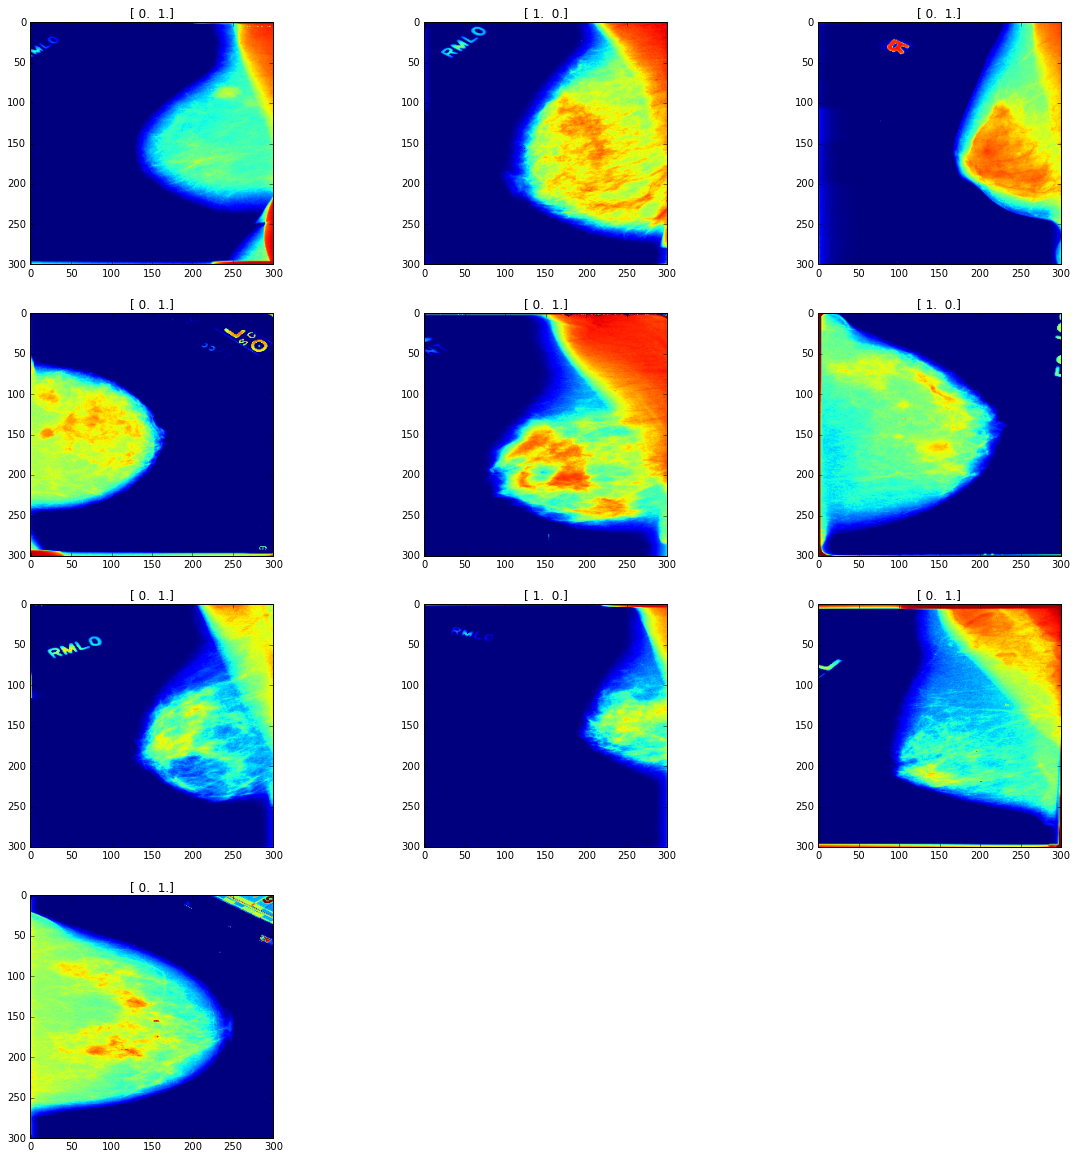

In [27]:

# randomly plot 10 images in train. The title is the y label.

samples = np.random.choice(range(len(train_x)), 10)
fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 4

i = 1
for sample in samples:
    reshape = np.reshape(train_x[sample], (300, 300))
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(str(train_y[sample]))
    i += 1
    plt.imshow(reshape)